In [2]:
import seaborn as sns
import numpy as np
import sys
sys.path.append("../code/")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
tensor = np.load("../2015-5appliances-true-agg.npy")

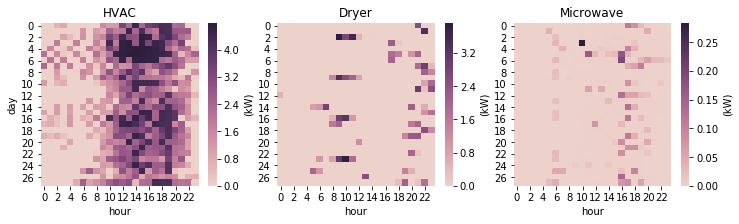

In [48]:
fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(12, 3))
ax = axes.flatten()
home = 51
cmap = sns.cubehelix_palette(as_cmap=True)

sns.heatmap(tensor[home, 1, 84:112]/1000, cmap=cmap, ax=ax[0], cbar_kws={'label': '(kW)'})
sns.heatmap(tensor[home, 3, 84:112]/1000, cmap=cmap, ax=ax[1], cbar_kws={'label': '(kW)'})
sns.heatmap(tensor[home, 5, 84:112]/1000, cmap=cmap, ax=ax[2], cbar_kws={'label': '(kW)'})
ax[0].set_ylabel('day')
ax[0].set_xlabel('hour')
ax[1].set_xlabel('hour')
ax[2].set_xlabel('hour')
ax[0].set_title('HVAC')
ax[1].set_title('Dryer')
ax[2].set_title('Microwave')
plt.savefig("./figure/heatmap_home.pdf", format='pdf')